## Setup

In [0]:
from google.colab import drive # import drive from google colab

In [2]:
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
WAKU_DIR = !find '/content/drive' -type d -name "WAKU"
WAKU_DIR = WAKU_DIR[0]
print(WAKU_DIR)

^C
/content/drive/My Drive/Marshall Scholarship/UCL/NLP Class/Code/WAKU


In [5]:
%cd $WAKU_DIR

/content/drive/My Drive/Marshall Scholarship/UCL/NLP Class/Code/WAKU


In [6]:
# install conda
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
sys.path.append('../')

--2020-03-28 21:27:49--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M  43.2MB/s    in 1.3s    

2020-03-28 21:27:51 (43.2 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk

In [7]:
# install TSNE CUDA. Ensure that cuda101 is replaced with cuda<major><minor> for your appropriate CUDA version
## NOTE -- when installing tsne cuda you will have to enter a 'y' to continue with the installation once. So don't start this cell and leave it expecting to finish on its own.
!conda install tsnecuda cuda101 -c cannylab

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.4
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda

In [9]:
import numpy as np
import pickle
import time
from datetime import datetime
import re
import os 
import io 
from os import path
from os.path import join  
from scipy.stats import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
import time 

import requests
import gzip
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tsnecuda
from tsnecuda import TSNE as TSNECUDA
torch.manual_seed(0)

from waku.word_analogies.base import get_wordanalogy_scores
from waku.word_intrusion.base import evaluate as word_intrusion_experiment
from waku.word_similarity.base import evaluate as ws_evaluate
from waku.sentiment_analysis.trainer import evaluate as sa_evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)

#TSNE code must be run on CUDA
if 'cuda' not in str(device):
    raise ValueError("This code must be run on a GPU")

Device used:  cuda


## Experiments

In [0]:
def sentiment_analysis_experiment(embedding_dict, embedding_weights):
    
    checkpoint_filepath = 'checkpoint.pth.tar'
    SST_filepath = WAKU_DIR + 'raw_data/SST/'
    
    test_accuracy = sa_evaluate(embedding_weights, SST_filepath, embedding_dict, checkpoint_filepath)
    
    return test_accuracy

In [ ]:
def word_similarity_experiment(embedding_dict, embedding_weights):
    sim_data_path = WAKU_DIR + 'raw_data/'
    sim_score, _ = ws_evaluate(embedding, sim_data, word2index, verbose=False)
    
    return sim_score

In [0]:
def word_analogy_experiment(embedding_dict, embedding_weights):
    # path_to_questionwords_dataset = !find '/content/drive' -type d -name "raw"
    # path_to_questionwords_dataset = path_to_questionwords_dataset[0]
    path_to_questionwords_dataset = WAKU_DIR + '/raw_data/questions-words.txt'
    scores, total_correct, total_found, total_accuracy, total_time = get_wordanalogy_scores(path_to_questionwords_dataset, embedding_dict, embedding_weights, True, verbose = False) # False means we have embeddings for uppercased words, True means embeddings for lowercase
    return total_accuracy

In [0]:
def run_tasks(paths_list):
    
    scores = np.zeros(shape=(len(paths_list),9))

    for i in range(len(paths_list)):
  
        # sentiment analysis
        tic = time.perf_counter()
        sa_score = sentiment_analysis_experiment(word2index, embedding_weights)
        toc = time.perf_counter()
        scores[i,1] = sa_score
        scores[i,2] = toc-tic
        print("Sentiment Score: ", sa_score)
        
        # intrusion
        tic = time.perf_counter()
        intrusion_score = word_intrusion_experiment(embedding_weights, k=5, N=10, acc_filepath=None, verbose=False)
        toc = time.perf_counter()
        scores[i,3] = intrusion_score
        scores[i,4] = toc-tic
        print("Intrusion Score: ", intrusion_score)

        # similarlity
        tic = time.perf_counter()
        sim_score = word_similarity_experiment(embedding_dict, embedding_weights)
        toc = time.perf_counter()
        scores[i,5] = similarlity_score
        scores[i,6] = toc-tic
        print("Similarity Score: ", similarlity_score)

        # word analogy 
        tic = time.perf_counter()
        wa_score = word_analogy_experiment(word2index, embedding_weights)
        toc = time.perf_counter()
        scores[i,7] = wa_score
        scores[i,8] = toc-tic
        print("Analogy score: ", wa_score)

    return scores

In [0]:
# read pickle file into dictionary
def load_pickle(filepath):
    # file path must end with .pickle
    pickle_in = open(filepath,"rb")
    emb_dict = pickle.load(pickle_in)
    return emb_dict

# load using helper function
dict_path = WAKU_DIR  + '/embeddings/word2index.pickle'
word2index = load_pickle(dict_path)

## t-SNE plot for Hoyer

In [0]:
def plot_tsne(X, mapping, n_iter=500, n_jobs = None):
    tsne = TSNECUDA(n_components = 2)

    fig = plt.figure(figsize=(30,30))
    ax = fig.gca()
    
    trans = tsne.fit_transform(X)

    coordinates = zip(*trans)
    ax.scatter(*coordinates)

    LABELSIZE = 30
    for i in range(len(trans)):
        ax.annotate(mapping[i], xy=trans[i], textcoords='data', size = LABELSIZE)
    
    plt.grid()
    plt.show()

    return fig

In [0]:
def t_SNE(embedding_dict, embedding_weights):
    # 2D
    sample_indices = list(range(100,200))
    sample_indices = []
    sample_indices.extend([embedding_dict[i] for i in ['german', 'english', 'french', 'spanish', 'british', 'american', 'italian', 'indian', 'chinese', 'thai', 'mexican', 'canadian', 'greek', 'russian']])
    sample_indices.extend([embedding_dict[name] for name in ['girl', 'boy', 'queen', 'king', 'man', 'woman', 'basketball', 'football', 'cat', 'dog', 'love', 'hate', 'son', 'daughter', 'country', 'city', 'state']])
    sample_indices.extend([embedding_dict[name] for name in ['prince', 'princess', 'small', 'large', 'big', 'life', 'death']])
    sample_indices.extend([embedding_dict[name] for name in ['university', 'school', 'college', 'teacher', 'math', 'algebra', 'calculus', 'history', 'art', 'science']])
    sample_indices.extend([embedding_dict[name] for name in ['aries', 'taurus', 'gemini', 'cancer', 'leo', 'virgo', 'libra', 'scorpio', 'sagittarius', 'capricorn', 'aquarius', 'pisces']])
    sample_indices.extend([embedding_dict[name] for name in ['bird', 'deer', 'bear', 'dog', 'cat', 'lion', 'frog', 'elephant', 'giraffe', 'fox', 'hippopotamus', 'monkey', 'turtle', 'snake', 'fish']])
    sample_indices.extend([embedding_dict[name] for name in ['mom', 'dad', 'son', 'daughter', 'family', 'grandmother', 'grandfather', 'brother', 'sister']])

    sample_indices = list(set(sample_indices))
    index2word = {value: key for key, value in embedding_dict.items()}
    subsample_weights = embedding_weights[sample_indices]
    sub_mapping = [index2word[i] for i in sample_indices]
    plot_tsne(subsample_weights, sub_mapping)

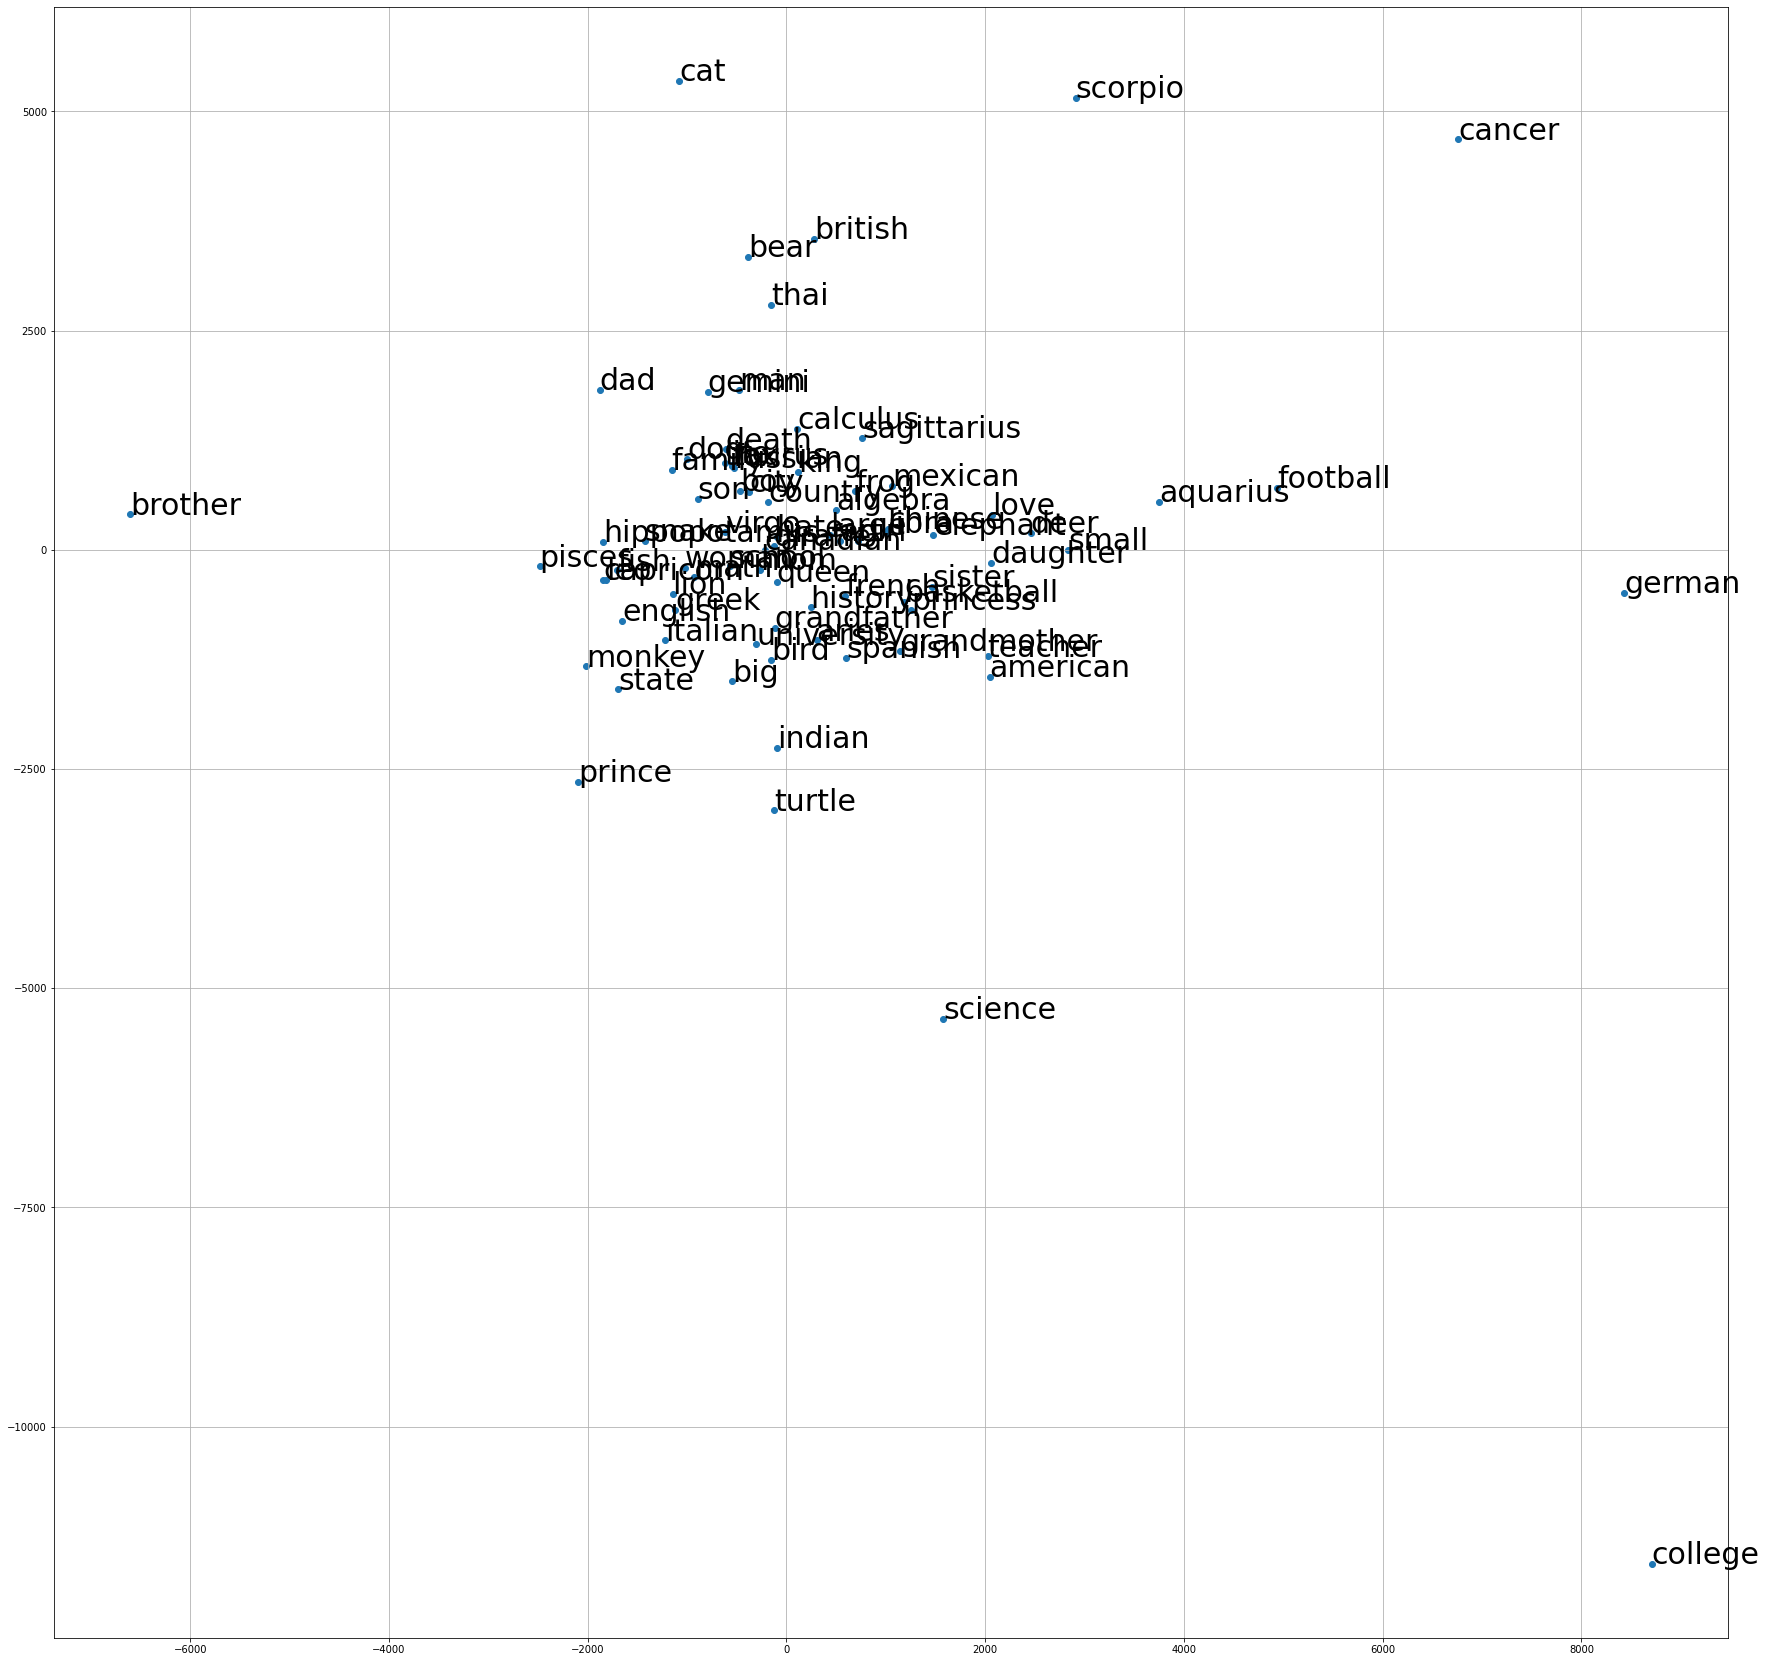

In [29]:
# Have verified this works for analogies and t-SNE -- Aneesh

hoyer_10_path = WAKU_DIR + '/embeddings/hoyer_10.0/'+'300_10.0_90_embeddings.npz'
hoyer_1e_05_path = WAKU_DIR + '/embeddings/hoyer_1e-05/'+'300_1e-05_90_embeddings.npz'

# run_tasks([hoyer_1e_05_path]) I ran this after commenting out SA WS and WI 

hoyer_10_embeds = np.load(hoyer_10_path)['a']
t_SNE(embedding_dict, hoyer_10_embeds)